# **Video Violence detection**

In [14]:
! pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e4/14/d795bb156f8cc10eb1dcfe1332b7dbb8405b634688980aa9be8f885cc888/tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
  Obtaining dependency information for tensorflow-intel==2.16.1 from https://files.pythonhosted.org/packages/e0/36/6278e4e7e69a90c00e0f82944d8f2713dd85a69d1add455d9e50446837ab/tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7

In [16]:
! pip install keras scikit-learn numpy tqdm

In [22]:
! pip install imgaug

  Obtaining dependency information for imgaug from https://files.pythonhosted.org/packages/66/b1/af3142c4a85cba6da9f4ebb5ff4e21e2616309552caca5e8acefe9840622/imgaug-0.4.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for Shapely from https://files.pythonhosted.org/packages/29/cd/763817c27e6cb6d04ffd477a5dcdfdd71bc3fb640f5748c9f2c1cd08ba52/shapely-2.0.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/948.0 kB ? eta -:--:--
   ---------------------------------------- 10.2/948.0 kB ? eta -:--:--
   - ------------------------------------- 41.0/948.0 kB 487.6 kB/s eta 0:00:02
   ------------------ --------------------- 440.3/948.0 kB 3.9 MB/s eta 0:00:01
   ---------------------------------------  942.1/948.0 kB 6.6 MB/s eta 0:00:01
   ---------------------------------------- 948.0/948.0 kB 5.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------  1.4/1.4 MB 30.9

In [2]:

# @title Import libraries

import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))


Windows-10-10.0.19045-SP0


And will set Numpy, Python and Tensorflow seeds to get consistent results on every execution

In [3]:
import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.16.1


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [19]:
# @title Import the data
# Discard output of this cell
%%capture

data_dir = 'Violence detection dataset/Real Life Violence Dataset/NonViolence'
!unzip x data_dir

UsageError: Line magic function `%%capture` not found.


In [5]:
MyDrive = '/kaggle/working'
PROJECT_DIR = 'Violence detection dataset'

# **Preprocessing**

In [4]:
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)

    import math
    rate = math.floor(vidcap.get(3))
    count = 0

    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()

        if success:
            # skipping frames to avoid duplications
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))

                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)

                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)

            count += 1
        else:
            break

    vidcap.release()
    pass
    return ImageFrames

In [7]:
%%time
from tqdm import tqdm

VideoDataDir = PROJECT_DIR + '/Real Life Violence Dataset'
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir(VideoDataDir + '/Violence')),
              len(os.listdir(VideoDataDir + '/NonViolence'))))

X_original = []
y_original = []

print('i choose 700 videos out of 2000, cuz of memory issue')
CLASSES = ["NonViolence", "Violence"]
#700 <- 350 + 350

for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:350])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

we have 
1000 Violence videos 
1000 NonViolence videos
i choose 700 videos out of 2000, cuz of memory issue


100%|██████████| 350/350 [07:35<00:00,  1.30s/it]

CPU times: total: 15min 58s
Wall time: 12min 10s


In [8]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)


13979

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

# **Model Training**

In [11]:
! pip install imutils
clear_output()


In [12]:

import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

from keras.layers import Input
from keras.models import Model
from keras.layers import Dropout,Flatten,Dense

import matplotlib.pyplot as plt

In [13]:
epochs = 50

from keras import regularizers
kernel_regularizer = regularizers.l2(0.0001)

from keras.applications.mobilenet_v2 import MobileNetV2

def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(pooling='avg',
                            include_top=False,
                            input_tensor=input_tensor)

    headModel = baseModel.output
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model

if TPU_INIT:
    with tpu_strategy.scope():
        model = load_layers()
else:
    model = load_layers()

model.summary()

C:\Users\Evrard\AppData\Local\Temp\ipykernel_7280\2703212479.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(pooling='avg',


Compiling model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 4

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [15]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True,
                                 verbose = 1, min_delta = .00075)

PROJECT_DIR = MyDrive + '/RiskDetection'

lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [16]:
print('Training head...')
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for MobileNetV2')
model.load_weights(checkpoint_filepath)

Training head...
Epoch 1/50
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5225 - loss: 0.8224
Epoch 1: val_loss improved from inf to 0.66659, saving model to ModelWeights.weights.h5
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 286s 110ms/step - accuracy: 0.5225 - loss: 0.8223 - val_accuracy: 0.6309 - val_loss: 0.6666 - learning_rate: 1.0000e-05
Epoch 2/50
2446/2447 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6790 - loss: 0.5940
Epoch 2: val_loss improved from 0.66659 to 0.47074, saving model to ModelWeights.weights.h5
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 234s 96ms/step - accuracy: 0.6791 - loss: 0.5940 - val_accuracy: 0.7783 - val_loss: 0.4707 - learning_rate: 1.8000e-05
Epoch 3/50
2446/2447 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8161 - loss: 0.4219
Epoch 3: val_loss improved from 0.47074 to 0.36106, saving model to ModelWeights.weights.h5
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 221s 90ms/step - accuracy: 0.8161 - loss: 0.4218 - val_accuracy: 0.8453 - val_loss: 0.3611 - learning_rate: 2.60

In [17]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i

def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)

------------------------------------------------------------------------------------------
Best Epochs:  41
Accuracy on train: 0.9523760676383972 	Loss on train: 0.13539892435073853
Accuracy on test: 0.9422985315322876 	Loss on test: 0.159955695271492


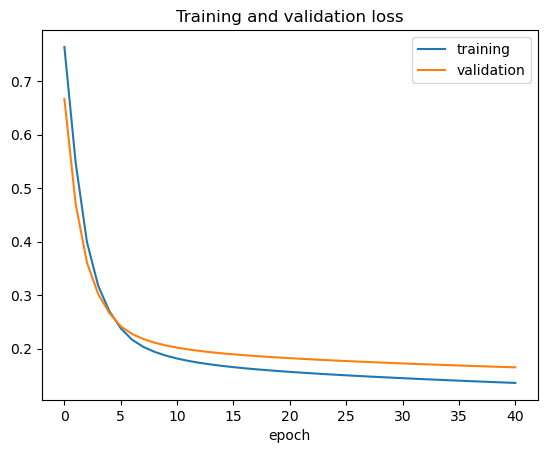

<Figure size 640x480 with 0 Axes>

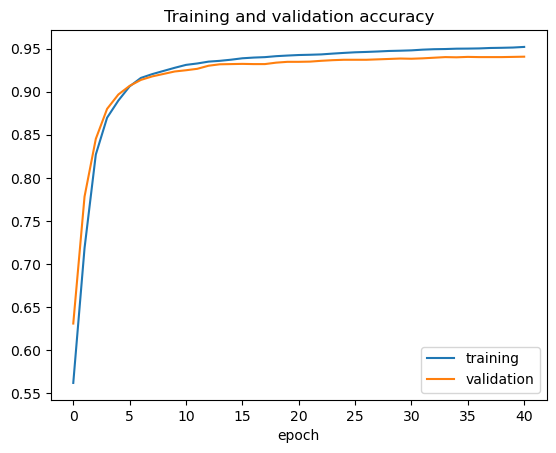

------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [18]:
model_summary(model, history)

# **Evaluation on test set**

In [19]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 317ms/step


> Correct Predictions: 3952
> Wrong Predictions: 242


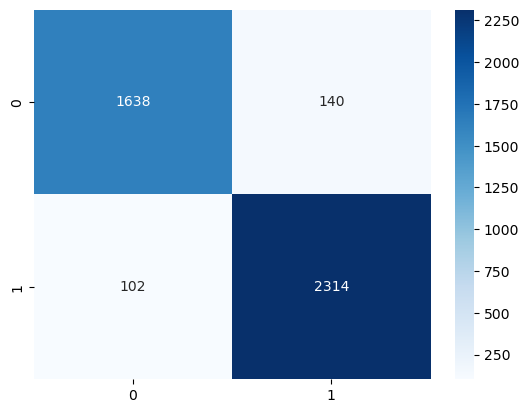

              precision    recall  f1-score   support

 NonViolence       0.94      0.92      0.93      1778
    Violence       0.94      0.96      0.95      2416

    accuracy                           0.94      4194
   macro avg       0.94      0.94      0.94      4194
weighted avg       0.94      0.94      0.94      4194



In [22]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds,
                           target_names=["NonViolence", "Violence"]))

In [23]:
args_model = "modelnew.h5"
model.save(args_model)

In [10]:
# Load the model
from tensorflow.keras.models import load_model

args_model = load_model("modelnew.h5")

import math

# Function to preprocess a video and make predictions
def predict_violence(video_path):
    # Extract frames from the video
    frames = video_to_frames(video_path)
    # Preprocess each frame
    preprocessed_frames = [preprocess_frame(frame) for frame in frames]
    # Convert preprocessed frames to a numpy array
    input_data = np.array(preprocessed_frames)
    # Make predictions using the loaded model
    predictions = args_model.predict(input_data)
    # Calculate the average prediction score
    avg_prediction = np.mean(predictions)
    # Define a threshold for classifying the video as violent
    threshold = 0.5  # You can adjust this threshold as needed
    # Determine if the video is violent or not based on the average prediction score
    if avg_prediction >= threshold:
        return "Violent"
    else:
        return "Non-violent"

# Path to the video file
video_path = "Asma-vs-pablo.mp4"
# Make predictions on the video
video_classification = predict_violence(video_path)
print("Video classification:", video_classification)


ValueError: math domain error

In [2]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
import cv2
import numpy as np

app = Flask(__name__)

# Load the model
model = load_model("modelnew.h5")

# Function to preprocess a single frame
def preprocess_frame(frame):
    # Resize the frame to IMG_SIZE
    resized_frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
    # Normalize pixel values
    normalized_frame = resized_frame / 255.0
    return normalized_frame

# Function to preprocess a video and make predictions
def predict_violence(video_path):
    # Extract frames from the video
    frames = video_to_frames(video_path)
    # Preprocess each frame
    preprocessed_frames = [preprocess_frame(frame) for frame in frames]
    # Convert preprocessed frames to a numpy array
    input_data = np.array(preprocessed_frames)
    # Make predictions using the loaded model
    predictions = model.predict(input_data)
    # Calculate the average prediction score
    avg_prediction = np.mean(predictions)
    # Define a threshold for classifying the video as violent
    threshold = 0.5  # You can adjust this threshold as needed
    # Determine if the video is violent or not based on the average prediction score
    if avg_prediction >= threshold:
        return "Violent"
    else:
        return "Non-violent"

@app.route('/predict', methods=['POST'])
def predict():
    # Check if the 'file' key is in the request
    if 'file' not in request.files:
        return jsonify({'error': 'No file part'})

    file = request.files['file']

    # Check if the file is empty
    if file.filename == '':
        return jsonify({'error': 'No selected file'})

    # Check if the file is an allowed format (you can customize this based on your requirements)
    if file and file.filename.endswith(('.mp4', '.avi', '.mkv')):
        # Save the file to a temporary location
        video_path = 'temp_video.mp4'
        file.save(video_path)
        
        # Make predictions on the video
        classification = predict_violence(video_path)

        # Delete the temporary video file
        os.remove(video_path)

        return jsonify({'classification': classification})
    else:
        return jsonify({'error': 'Unsupported file format'})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (windowsapi)


SystemExit: 1